In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from support_code.model import DQN
from support_code.env import TradingEnv
from support_code.functions import fetch_data, buy_and_hold, unpickle_model, corr

In [2]:
warnings.simplefilter('ignore')

In [3]:
stock = 'NFLX'
print(f'Stock: {stock}')

Stock: NFLX


In [4]:
df = fetch_data(stock.lower()+'_df')

---

In [5]:
starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance, training=False)

env.verbose=1
env.reset();

In [6]:
done = False
obs = env.reset()
start = env.current_step

stock_performance = []
model_performance = []
actions = []

while not done:
    
    stock_performance.append(df.loc[env.current_step]['close'])
    model_performance.append(env.net_worth)
        
    action = np.random.randint(env.action_space.n)
    obs, rewards, done, info = env.step(action)

    actions.append(env._actions[action])
    
end = env.current_step

current price 328.52999900000003
action -1.0
total possible to sell 0
number sold 0.0
profit from selling 0.0
balance 1000000.0 shares held 0.0
previous net worth 1000000 current net worth 1000000.0

current price 326.130005
action 0.5
total possible to buy 3063.1986744089954
number bought 1531.5993372044977
cost of buying 499999.99999999994
balance 500000.00000000006 shares held 1531.5993372044977
previous net worth 1000000.0 current net worth 999500.4995004996

current price 328.190002
action -0.5
total possible to sell 1531.5993372044977
number sold 765.7996686022489
profit from selling 251076.4669754012
balance 751076.4669754013 shares held 765.7996686022489
previous net worth 999500.4995004996 current net worth 1002404.2617455727

current price 325.22000099999997
action -1.0
total possible to sell 765.7996686022489
number sold 765.7996686022489
profit from selling 248804.3156196344
balance 999880.7825950356 shares held 0.0
previous net worth 1002404.2617455727 current net worth 99

current price 418.97000099999997
action 0.25
total possible to buy 1967.8087828179575
number bought 491.9521957044894
cost of buying 206319.32513818835
balance 618957.975414565 shares held 1166.459976032483
previous net worth 1100645.1018716567 current net worth 1107669.7127393542

current price 415.630005
action 0.5
total possible to buy 1487.7165467848893
number bought 743.8582733924446
cost of buying 309478.9877072825
balance 309478.9877072825 shares held 1910.3182494249277
previous net worth 1107669.7127393542 current net worth 1103464.5712673564

current price 418.649994
action -1.0
total possible to sell 1910.3182494249277
number sold 1910.3182494249277
profit from selling 798954.9689361766
balance 1108433.9566434592 shares held 0.0
previous net worth 1103464.5712673564 current net worth 1108433.9566434592

current price 413.5
action -0.5
total possible to sell 0.0
number sold 0.0
profit from selling 0.0
balance 1108433.9566434592 shares held 0.0
previous net worth 1108433.956643

current price 346.459991
action -0.25
total possible to sell 0.0
number sold 0.0
profit from selling 0.0
balance 923442.8579430223 shares held 0.0
previous net worth 923442.8579430223 current net worth 923442.8579430223

current price 348.679993
action 0.5
total possible to buy 2645.750705878375
number bought 1322.8753529391875
cost of buying 461721.4289715111
balance 461721.4289715112 shares held 1322.8753529391875
previous net worth 923442.8579430223 current net worth 922981.5977742197

current price 348.410004
action -1.0
total possible to sell 1322.8753529391875
number sold 1322.8753529391875
profit from selling 460442.10400203464
balance 922163.5329735458 shares held 0.0
previous net worth 922981.5977742197 current net worth 922163.5329735458

current price 355.929993
action 0.0
balance 922163.5329735458 shares held 0.0
previous net worth 922163.5329735458 current net worth 922163.5329735458

current price 369.950012
action -1.0
total possible to sell 0.0
number sold 0.0
profit fr

In [7]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=stock_performance,
    fee=env.fee
    )

In [8]:
date_range = pd.to_datetime(df['date'].values[start:end])

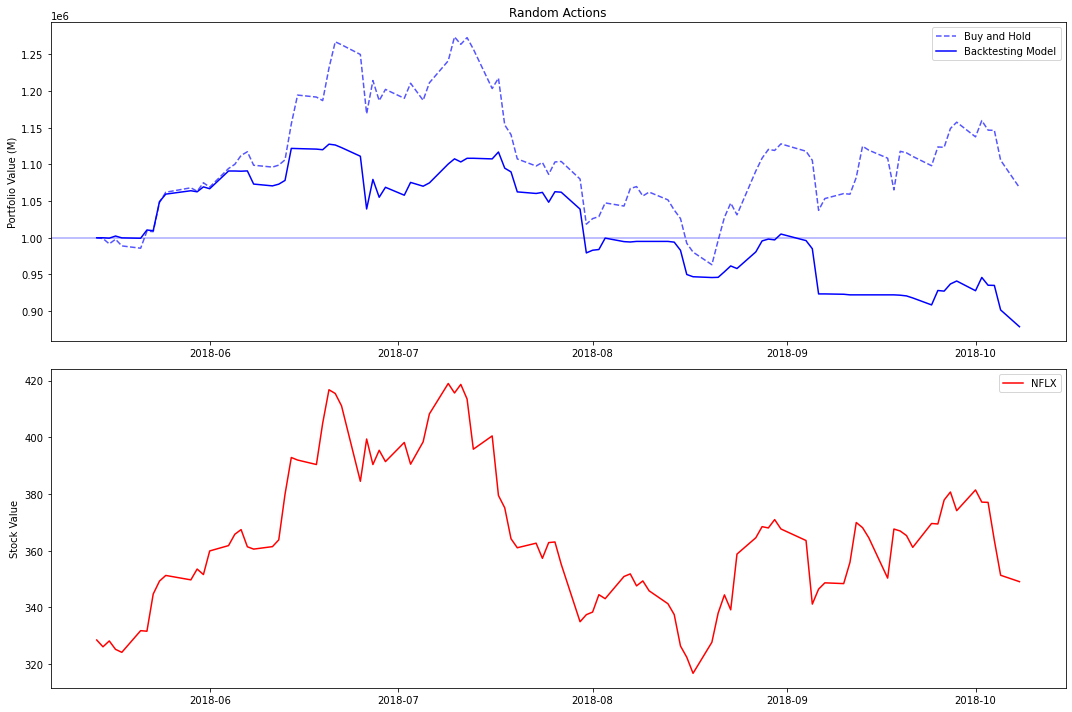

In [9]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(date_range, long, 'b--', alpha=0.6667, label='Buy and Hold')
ax1.plot(date_range, model_performance, 'b-', label='Backtesting Model')
ax1.axhline(env.balance_init, alpha=0.3333, color='blue')
ax1.set_ylabel('Portfolio Value (M)')
ax1.set_title('Random Actions')
ax1.legend()

ax2.plot(date_range, stock_performance, 'r-', label=stock)
ax2.set_ylabel('Stock Value')
ax2.legend()

fig.tight_layout()
fig.savefig(f'./assets/{stock}_performance_rand.jpg');
fig.show();

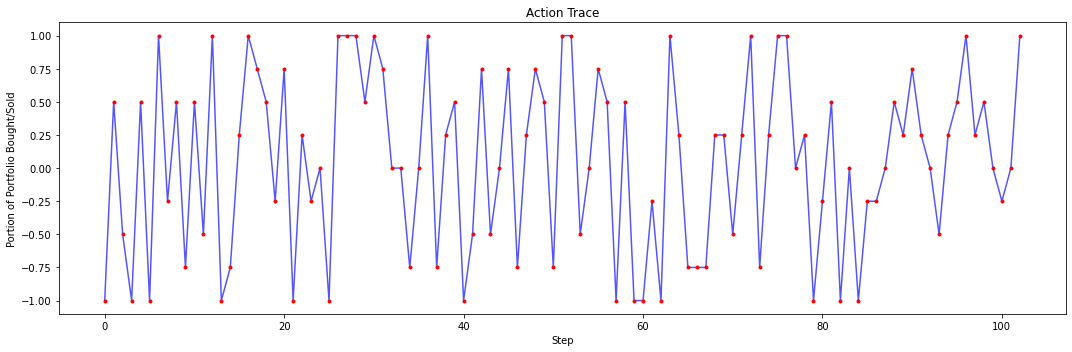

In [10]:
plt.figure(figsize=(15,5))
plt.plot(actions, 'b-', alpha=0.6667)
plt.plot(actions, 'r.')

plt.title('Action Trace')
plt.xlabel('Step')
plt.ylabel('Portion of Portfolio Bought/Sold')

plt.tight_layout()
plt.savefig(f'./assets/{stock}_actions_rand.png')
plt.show();

In [11]:
print(corr(actions, stock_performance))

0.1773575441708497


---

In [19]:
dqn_solver = unpickle_model(DQN, path='model_info_nflx')
dqn_solver.alpha = 0.01

In [20]:
starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance, training=False)

env.verbose=0
env.reset();

In [21]:
stock_performance = []
model_performance = []
actions = []
    
state = env.reset()
start = env.current_step
done = False    

while not done:

    action = dqn_solver.act(state)
    next_state, reward, done, info = env.step(action)

    dqn_solver.remember(state, action, reward, next_state, done)
    state = next_state

    actions.append(action)
    model_performance.append(env.net_worth)  
    stock_performance.append(df.loc[env.current_step]['close'])

    #dqn_solver.replay();  

In [22]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=stock_performance,
    fee=env.fee
    )

In [23]:
date_range = pd.to_datetime(df['date'].values[start:env.current_step])

In [24]:
assert len(date_range) == len(actions) == len(model_performance) == len(stock_performance) == len(long)

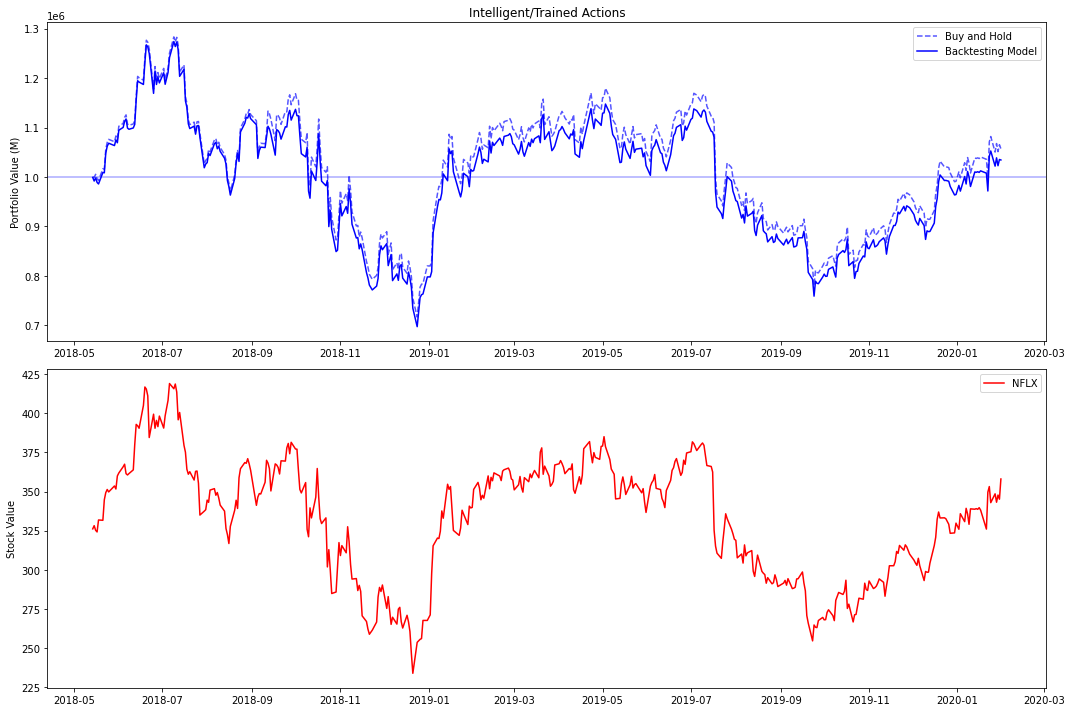

In [25]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(date_range, long, 'b--', alpha=0.6667, label='Buy and Hold')
ax1.plot(date_range, model_performance, 'b-', label='Backtesting Model')
ax1.axhline(env.balance_init, alpha=0.3333, color='blue')
ax1.set_ylabel('Portfolio Value (M)')
ax1.set_title('Intelligent/Trained Actions')
ax1.legend()

ax2.plot(date_range, stock_performance, 'r-', label=stock)
ax2.set_ylabel('Stock Value')
ax2.legend()

fig.tight_layout()
fig.savefig(f'./assets/{stock}_performance_trained.jpg');
fig.show();

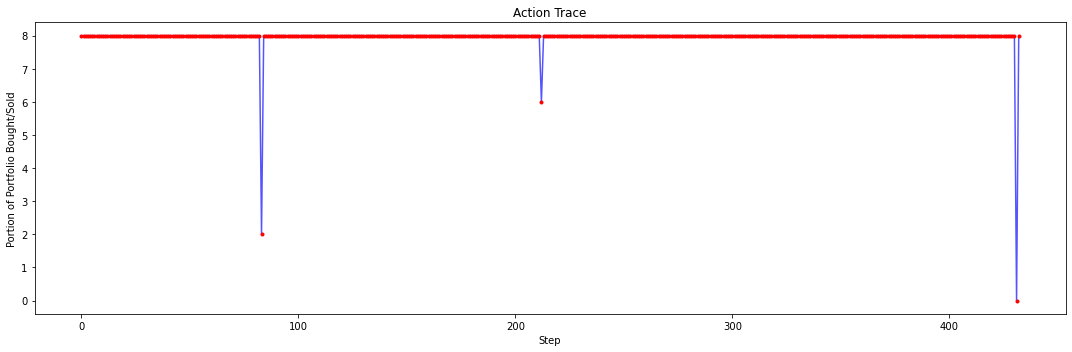

In [26]:
plt.figure(figsize=(15,5))
plt.plot(actions, 'b-', alpha=0.6667)
plt.plot(actions, 'r.')

plt.title('Action Trace')
plt.xlabel('Step')
plt.ylabel('Portion of Portfolio Bought/Sold')

plt.tight_layout()
plt.savefig(f'./assets/{stock}_actions_trained.png')
plt.show();

In [27]:
corr(actions, stock_performance)

0.05040179050060357